# ADA final exam (winter semester 2019/2020)

A friend of yours wants to start a YouTube channel and ideally earn some money via ads. However, there are so many channels and videos out there that your friend has no idea where to even start. Fortunately, they know that you have taken ADA and think you might help them out by analyzing the videos that are currently on YouTube.

The data you are provided with is a subset of YouTube videos, with videos from some of the giant channels in two categories: "Gaming" and "How-to & Style", which are the categories your friend is choosing between. The dataset contains a lot of videos, with data on those videos including their titles, their total number of views in 2019, their tags and descriptions, etc. The data is, in gzip-compressed format, contained in the `data/` folder, as the file `youtube.csv.gz`.

The three tasks A, B and C are **independent** of each other, and you can solve any combination of them. The exam is designed for more than 3 hours, so don't worry if you don't manage to solve everything; you can still score a 6.

You need to run the following two cells to read and prepare the dataset.

In [1]:
''' Some minimalistic imports '''
import pandas as pd
import random
import gzip
import operator
import time
from urllib.parse import unquote

import math
import numpy as np
import scipy.stats as stats
import sklearn

import networkx as nx

from IPython.display import Image
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sklearn.model_selection
import sklearn.linear_model
import sklearn.metrics

from operator import itemgetter
from collections import Counter

In [3]:
import pandas as pd
import numpy as np

In [4]:
youtube = pd.read_csv('data/youtube.csv.gz', compression='gzip')
youtube.upload_date = pd.to_datetime(youtube.upload_date)

## Dataset description

Each row of the dataset corresponds to one video that was uploaded to YouTube. There are 11 columns:
'channel', 'upload_date', 'title', 'categories', 'tags', 'duration',
       'view_count', 'average_rating', 'height', 'width', 'channel_cat'.
- `channel`: The channel (account) on which the video was uploaded.
- `upload_date`: The date on which the video was uploaded (Pandas Timestamp object).
- `title`: The title of the video.
- `tags`: A list of words that describe the video.
- `duration`: The duration of the video in seconds.
- `view_count`: The number of times the video was watched.
- `average_rating`: The average score with which the viewers rated the video (1-5).
- `height`: The height of the video in pixels.
- `width`: The width of the video in pixels.
- `channel_cat`: The category of the channel on which this video was uploaded. This dataset only contains videos from channels from the 'Gaming' and the 'Howto & Style' category.

# Task A: Welcome to the exam!

All of Task A refers to the videos that were published between and including 2010 and 2018.

## A1: A growing platform?

You would first like to know whether YouTube in general is the right platform to invest time into.

1. Using the appropriate plot type, plot the number of videos published per year between and including 2010 and 2018.

In [8]:
youtube['year'] = youtube.upload_date.dt.year 

In [15]:
# Restrict dataset to years between 2010 and 2018
youtube_A = youtube[(2010 <= youtube['year']) & (youtube['year'] <= 2018)]

In [36]:
year_counts = youtube_A.year.value_counts().sort_index()
year_counts

2010     2731
2011     7929
2012    12987
2013    18309
2014    20216
2015    15704
2016    15966
2017    17356
2018    16665
Name: year, dtype: int64

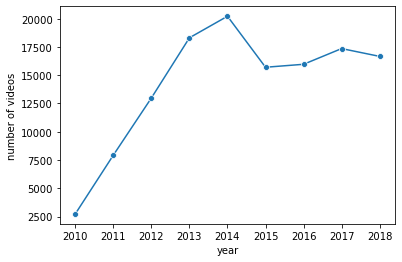

In [42]:
sns.lineplot(x=year_counts.index, y=year_counts.values, marker="o");
plt.xlabel('year')
plt.ylabel('number of videos');

2. Now for each year, plot the number of channels that have been created between the beginning of 2010 and the end of that year. A channel is considered to be created at the time at which they upload their first video.

In [62]:
# Sort by channel and year
youtube_A = youtube_A.sort_values(by=['channel', 'year'])

# Count the number of channel created per year
year_creation = youtube_A.groupby('channel').year.head(1).value_counts()
year_creation = year_creation.sort_index()

In [134]:
# Cumulative sum - number of channels created between beginning of 2010 and end of index year
year_creation = year_creation.cumsum()
year_creation

2010     49
2011     76
2012    112
2013    133
2014    151
2015    164
2016    176
2017    193
2018    195
Name: year, dtype: int64

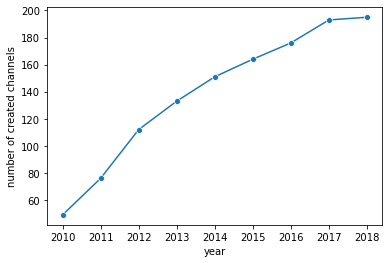

In [135]:
sns.lineplot(x=year_creation.index, y=year_creation.values, marker="o");
plt.xlabel('year')
plt.ylabel('number of created channels');

3. Normalize the number of videos published each year by the number of channels that have been created between the beginning of 2010 and the end of that year, and plot these quantities. Do seperate plots for gaming channels, how-to channels, and both together. Can you conclude from the plot that both gaming and how-to channels have been becoming less and less active recently? Why, or why not?

In [124]:
# Repeat the analysis separating by category
year_counts_cat = youtube_A.groupby('channel_cat').year.value_counts().sort_index()
year_counts_cat = year_counts_cat.unstack()
year_counts_cat

year,2010,2011,2012,2013,2014,2015,2016,2017,2018
channel_cat,,,,,,,,,
Gaming,1560,5563,8922,13511,15076,10192,8492,8047,7144
Howto & Style,1171,2366,4065,4798,5140,5512,7474,9309,9521


In [161]:
# Repeat the analysis separating by category
year_creation_cat = youtube_A.groupby('channel')[['year', 'channel_cat']].head(1)
year_creation_cat = year_creation_cat.groupby('channel_cat').year.value_counts().sort_index()
# year_creation_cat.append({['Gaming', 2018]: 0})
year_creation_cat = year_creation_cat.groupby('channel_cat').cumsum()
year_creation_cat = year_creation_cat.unstack()
year_creation_cat

year,2010,2011,2012,2013,2014,2015,2016,2017,2018
channel_cat,,,,,,,,,
Gaming,24.0,41.0,61.0,73.0,82.0,91.0,94.0,99.0,NaN
Howto & Style,25.0,35.0,51.0,60.0,69.0,73.0,82.0,94.0,96.0


In [162]:
# Manually fill the NaN with the value of the previous year (there are no new Gaming channels in 2018)
year_creation_cat.loc['Gaming', 2018] = 99.0

In [173]:
year_normalized = year_counts_cat / year_creation_cat

In [174]:
# Normalize stats for all channels and append them
all_normalized = year_counts / year_creation
year_normalized = year_normalized.append(pd.DataFrame([all_normalized.values], columns = all_normalized.index, index=['All']))
year_normalized

,2010,2011,2012,2013,2014,2015,2016,2017,2018
Gaming,65.000000,135.682927,146.262295,185.082192,183.853659,112.000000,90.340426,81.282828,72.161616
Howto & Style,46.840000,67.600000,79.705882,79.966667,74.492754,75.506849,91.146341,99.031915,99.177083
All,55.734694,104.328947,115.955357,137.661654,133.880795,95.756098,90.715909,89.927461,85.461538


In [175]:
# Prepare data for plotting
year_normalized = year_normalized.melt(ignore_index=False).reset_index().rename({'variable': 'year', 'index': 'category'}, axis=1)
year_normalized.head()

,category,year,value
0,Gaming,2010,65.000000
1,Howto & Style,2010,46.840000
2,All,2010,55.734694
3,Gaming,2011,135.682927
4,Howto & Style,2011,67.600000


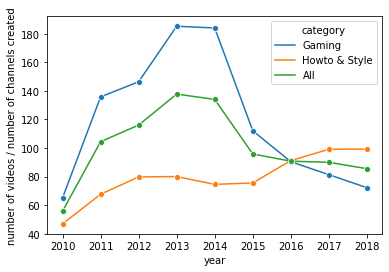

In [178]:
sns.lineplot(x='year', y='value', hue='category', data=year_normalized, marker='o')
plt.xlabel('year')
plt.ylabel('number of videos / number of channels created');

It seems that Gaming channels have become less active over time, while Howto & Style have undergone a surge in the last years.

## A2: The one thing we all love: cash money

Your friend is really keen on making money from their YouTube channel through ads and wants you to help them choose the most profitable channel category (Gaming or Howto & Style). The ad profit is directly proportional to the number of views of a video.

1. Since your friend wants to keep producing videos for several years to come, it might also be worth looking at the growth of the two categories.
  1. Compute the total number of views in each category per year for the years 2010-2018.
  2. Divide the yearly view count by the number of channels that posted a video in each category in each year. Plot these normalized counts.




In [202]:
views_yearly = youtube_A.groupby(['channel_cat', 'year']).view_count.sum()#.reset_index()
views_yearly.head()

channel_cat  year
Gaming       2010    7.792190e+08
             2011    2.500144e+09
             2012    6.189954e+09
             2013    1.503147e+10
             2014    2.497133e+10
Name: view_count, dtype: float64

In [310]:
views_yearly.groupby('channel_cat').sum()

channel_cat
Gaming           1.269254e+11
Howto & Style    7.707333e+10
Name: view_count, dtype: float64

In [203]:
# Number of videos by channel by year
videos_yearly = youtube_A.groupby(['channel_cat', 'channel', 'year']).title.count()

# Set a 1 for each entry: a row with a 1 for each year in with a channel has published at least a video
videos_yearly[:] = 1

# Sum the ones, grouping by category and year
videos_yearly = videos_yearly.groupby(['channel_cat', 'year']).sum()#.reset_index()
videos_yearly.head()

channel_cat  year
Gaming       2010    24
             2011    41
             2012    57
             2013    66
             2014    69
Name: title, dtype: int64

In [214]:
views_normalized = views_yearly / videos_yearly
views_normalized = views_normalized.reset_index().rename({0: 'view_normalized'}, axis=1)
views_normalized.head()

,channel_cat,year,view_normalized
0,Gaming,2010,3.246746e+07
1,Gaming,2011,6.097913e+07
2,Gaming,2012,1.085957e+08
3,Gaming,2013,2.277496e+08
4,Gaming,2014,3.619033e+08


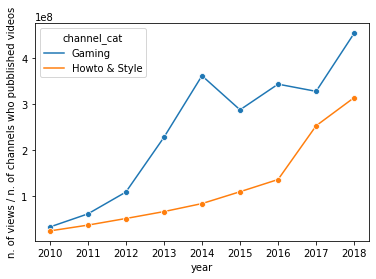

In [216]:
sns.lineplot(x='year', y='view_normalized', hue='channel_cat', data=views_normalized, marker='o')
plt.xlabel('year')
plt.ylabel('n. of views / n. of channels who pubblished videos');

2. Your friend's channel will be brand new, so you decide to look more closely at newer channels. For this question and all the following questions in A2, only consider channels that uploaded their first video in  2016 or later. Compute the total number of views in each category and divide it by the number of channels in that category.


In [272]:
first_videos = youtube_A.groupby('channel').year.head(1)
# List of creators (indexes) who uploaded their first video after 2016
creators = first_videos[first_videos >= 2016].index

# Convert indexes to creator names
creators = youtube_A2.loc[creators].channel.values
creators

array(['5-Minute Crafts', '5-Minute Crafts GIRLY', '5-Minute Crafts PLAY',
       'Anaysa', 'Antonio Garza', 'BRICO SYMPA', 'BRIGHT SIDE', 'Blossom',
       'Ceeday', 'Chris Smoove', 'Clash Royale', 'Crafty Panda',
       'Daequan Loco', 'Denis', 'Frost Diamond', 'GameGrumps',
       'Grandpa Kitchen', 'Health Tips for You', 'Homemade solutions',
       'Hong Giang DIY Slime', 'Indian Health', 'Izabela Stress',
       'Jess No Limit', 'MeLlamanFredy', 'SHORT TIME SECRET',
       'Satisfying Slime Videos', 'So Yummy', 'Tasty', 'Tom Slime',
       'Xyz Gyan', 'YourHealth'], dtype=object)

In [280]:
youtube_A2 = youtube_A[youtube_A.channel.isin(creators)]
youtube_A2.head()

,channel,upload_date,title,tags,duration,view_count,average_rating,height,width,channel_cat,year
84197,5-Minute Crafts,2016-12-30,How to make character snowflakes in less than ...,"['how to', 'diy']",65.0,93470.0,4.661972,1080.0,1920.0,Howto & Style,2016
84198,5-Minute Crafts,2016-12-30,How to change the color of your fresh flowers ...,"['diy', 'how to']",59.0,27450.0,4.707865,1080.0,1920.0,Howto & Style,2016
84199,5-Minute Crafts,2016-12-29,Foam science experiments that will blow your m...,"['how to', 'tutorial']",45.0,358140.0,4.749210,1080.0,1920.0,Howto & Style,2016
84200,5-Minute Crafts,2016-12-29,Creative Christmas hairstyle for little girls ...,"['tutorial', 'how to']",45.0,72104.0,4.772728,1080.0,1920.0,Howto & Style,2016
84201,5-Minute Crafts,2016-12-29,4 incredibly simple kitchen hacks l 5-MINUTE C...,"['tutorial', 'how to']",50.0,72056.0,4.463687,1080.0,1920.0,Howto & Style,2016


In [284]:
groups = youtube_A2.groupby('channel_cat')
groups.view_count.sum()  / groups.channel.unique().apply(lambda x: len(x))

channel_cat
Gaming           7.694004e+08
Howto & Style    1.212496e+09
dtype: float64

3. The number of views might be very unevenly over the different channels, and channels might upload different numbers of videos.
  1. Compute the mean number of views per video for each channel.
  2. Compute the mean of these means for each of the two categories. Print these values.
  3. Using bootstrapping, compute 95% confidence intervals for these two means. From this analysis, can you draw a recommendation for one of the two categories? Why, or why not?

In [297]:
means = youtube_A2.groupby(['channel_cat', 'channel']).view_count.mean()
means = means.reset_index()
means

,channel_cat,channel,view_count
0,Gaming,Ceeday,2.386543e+06
1,Gaming,Chris Smoove,5.275000e+05
2,Gaming,Clash Royale,1.944144e+06
3,Gaming,Daequan Loco,1.245950e+06
4,Gaming,Denis,2.074953e+06
5,Gaming,Frost Diamond,1.376930e+06
6,Gaming,GameGrumps,6.767778e+05
7,Gaming,Jess No Limit,1.324468e+06
8,Howto & Style,5-Minute Crafts,4.001437e+06
9,Howto & Style,5-Minute Crafts GIRLY,1.822314e+06


In [298]:
means.groupby('channel_cat').mean()

,view_count
channel_cat,
Gaming,1.444658e+06
Howto & Style,3.965565e+06


In [301]:
means_gaming

,channel_cat,channel,view_count
0,Gaming,Ceeday,2.386543e+06
1,Gaming,Chris Smoove,5.275000e+05
2,Gaming,Clash Royale,1.944144e+06
3,Gaming,Daequan Loco,1.245950e+06
4,Gaming,Denis,2.074953e+06
5,Gaming,Frost Diamond,1.376930e+06
6,Gaming,GameGrumps,6.767778e+05
7,Gaming,Jess No Limit,1.324468e+06


In [300]:
means_gaming = means[means.channel_cat == 'Gaming']
means_howto = means[means.channel_cat == 'Howto & Style']

In [306]:
stats.bootstrap([means_gaming.view_count.values], np.mean, confidence_level=0.95)

BootstrapResult(confidence_interval=ConfidenceInterval(low=1018824.7939184383, high=1867412.3927489193), standard_error=219143.50073599163)

In [308]:
stats.bootstrap([means_howto.view_count.values], np.mean, confidence_level=0.95)

BootstrapResult(confidence_interval=ConfidenceInterval(low=2753879.830465163, high=5957670.690933616), standard_error=784416.6070317226)

The analysis shows clearly that the average views for each channel are significantly higher for channels in the Howto & Style category rather than Gaming channels. This is statistically significant, since the 95% confidence interval do not intersect in any point. Therefore, my raccomandation to maximize the gain from ads would be to open a new Howto & Style channel.

# Task B: View forecasting (Machine Learning)

Your friend wants to figure out how they can optimize their videos for getting the maximum number of views (without using shocking thumbnails and clickbait titles). In this task, you will build a machine learning (ML) model for predicting the success of a video.

## B1: Get those shovels out again

1. For the prediction model, use all rows of the dataset, but keep only the following columns: `view_count, channel, upload_date, duration, average_rating, height, width`.

In [16]:
B_columns = ['view_count', 'channel', 'upload_date', 'duration', 'average_rating', 'height', 'width']
youtubeB = youtube[B_columns].copy()
youtubeB

,view_count,channel,upload_date,duration,average_rating,height,width
0,2541550.0,PewDiePie,2013-03-04,1126.0,4.886102,720.0,1280.0
1,1727646.0,PewDiePie,2013-03-04,903.0,4.951531,720.0,1280.0
2,1402747.0,PewDiePie,2013-03-04,806.0,4.962706,720.0,1280.0
3,4348296.0,PewDiePie,2013-03-03,909.0,4.937665,720.0,1280.0
4,1410659.0,PewDiePie,2013-03-03,834.0,4.957545,720.0,1280.0
...,...,...,...,...,...,...,...
139502,284147.0,cutepolish,2010-02-23,201.0,4.608439,480.0,640.0
139503,136278.0,cutepolish,2010-02-22,180.0,4.638451,480.0,640.0
139504,228384.0,cutepolish,2010-02-21,277.0,4.836411,480.0,640.0
139505,247053.0,cutepolish,2010-02-20,174.0,4.855700,480.0,640.0


2. Extract the upload year and upload month from the `upload_date` column into the two columns `upload_year` and `upload_month`, and remove `upload_date`.

In [22]:
youtubeB['upload_year'] = youtubeB.upload_date.dt.year
youtubeB['upload_month'] = youtubeB.upload_date.dt.month
youtubeB = youtubeB.drop('upload_date', axis=1)
youtubeB

,view_count,channel,duration,average_rating,height,width,upload_year,upload_month
0,2541550.0,PewDiePie,1126.0,4.886102,720.0,1280.0,2013,3
1,1727646.0,PewDiePie,903.0,4.951531,720.0,1280.0,2013,3
2,1402747.0,PewDiePie,806.0,4.962706,720.0,1280.0,2013,3
3,4348296.0,PewDiePie,909.0,4.937665,720.0,1280.0,2013,3
4,1410659.0,PewDiePie,834.0,4.957545,720.0,1280.0,2013,3
...,...,...,...,...,...,...,...,...
139502,284147.0,cutepolish,201.0,4.608439,480.0,640.0,2010,2
139503,136278.0,cutepolish,180.0,4.638451,480.0,640.0,2010,2
139504,228384.0,cutepolish,277.0,4.836411,480.0,640.0,2010,2
139505,247053.0,cutepolish,174.0,4.855700,480.0,640.0,2010,2


3. The entry in the channel column for a video indicates on which channel the video was uploaded. Encode this column via one-hot encoding.

In [26]:
youtubeB = pd.get_dummies(youtubeB)
youtubeB

,view_count,duration,average_rating,height,width,upload_year,upload_month,channel_5-Minute Crafts,channel_5-Minute Crafts GIRLY,channel_5-Minute Crafts PLAY,...,channel_grav3yardgirl,channel_iHasCupquake,channel_jacksepticeye,channel_jaipurthepinkcity,channel_jeffreestar,channel_speedyw03,channel_stampylonghead,channel_theRadBrad,channel_videogamedunkey,channel_windy31
0,2541550.0,1126.0,4.886102,720.0,1280.0,2013,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1727646.0,903.0,4.951531,720.0,1280.0,2013,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1402747.0,806.0,4.962706,720.0,1280.0,2013,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4348296.0,909.0,4.937665,720.0,1280.0,2013,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1410659.0,834.0,4.957545,720.0,1280.0,2013,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139502,284147.0,201.0,4.608439,480.0,640.0,2010,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
139503,136278.0,180.0,4.638451,480.0,640.0,2010,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
139504,228384.0,277.0,4.836411,480.0,640.0,2010,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
139505,247053.0,174.0,4.855700,480.0,640.0,2010,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


4. Split the data into a train (70%) and a test set (30%) with the appropriate function from sklearn, using 42 as the random seed.

In [35]:
y = youtubeB['view_count']
X = youtubeB.drop('view_count', axis=1)

In [36]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.7, random_state=42)

## B2: Who is the most viewed of them all?

1. Train a ridge regression model (i.e., an L2-regularized linear regression model) on the train set that predicts the view count from the other features. Find and use the optimal regularization parameter $\alpha$ from the set {0.001, 0.01, 0.1} via 3-fold cross validation.

In [77]:
parameters = {'alpha': [0.001, 0.01, 0.1]}

estimator = sklearn.linear_model.Ridge(random_state=42)
gs = sklearn.model_selection.GridSearchCV(estimator, parameters, cv=3)

In [78]:
gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=Ridge(random_state=42),
             param_grid={'alpha': [0.001, 0.01, 0.1]})

In [79]:
gs.best_params_

{'alpha': 0.1}

In [83]:
# Train model with the best alpha, 0.1
model = sklearn.linear_model.Ridge(alpha=0.1, random_state=42)
model.fit(X_train, y_train)

Ridge(alpha=0.1, random_state=42)

2. Report the mean absolute error that the model makes on the test set.

In [84]:
y_pred = model.predict(X_test)

In [85]:
sklearn.metrics.mean_absolute_error(y_test, y_pred)

1444649.5039951417

## B3: Checking our ambitions

To improve performance, you want to make the task of the ML model easier and turn it into a classification task. Now it only has to predict whether a video has a high view count (defined as being larger than the median of the view counts in the training set) or a low view count (defined as being smaller or equal to the median of the view counts in the training set).

1. Train a logistic regression model for this classification task. Find and use the optimal regularization parameter C (as defined in scikit-learn's documentation) from the set {1, 10, 100} via 3-fold cross validation. Use the random seed 42. _Hint_: If you get a warning about the training algorithm failing to converge, increase the maximum number of training iterations.

In [62]:
median = y_train.median()

In [75]:
# Create new binary y for classification
yb_train = (y_train > median).astype(int)
yb_test = (y_test > median).astype(int)
yb_train

50407     1
19656     0
11409     1
129767    1
99944     1
         ..
110268    0
119879    0
103694    0
131932    0
121958    0
Name: view_count, Length: 97654, dtype: int32

In [91]:
parameters = {'C': [1, 10, 100]}

estimator = sklearn.linear_model.LogisticRegression(max_iter=1000, random_state=42)
gs = sklearn.model_selection.GridSearchCV(estimator, parameters, cv=3)

In [92]:
gs.fit(X_train, yb_train)

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000, random_state=42),
             param_grid={'C': [1, 10, 100]})

In [93]:
gs.best_params_

{'C': 10}

In [97]:
# Train model with the best C, 10
model = sklearn.linear_model.LogisticRegression(max_iter=1000, C=10, random_state=42)
model.fit(X_train, yb_train)

LogisticRegression(C=10, max_iter=1000, random_state=42)

2. Compute the accuracy of the logistic regression model on the test set.

In [98]:
yb_pred = model.predict(X_test)

In [99]:
sklearn.metrics.accuracy_score(yb_test, yb_pred)

0.7480467350010752

## B4: ...something's not right.

You are satisfied with the model performance. In fact, you are a bit surprised at how good the model is given the relatively little amount of information about the videos. So you take a closer look at the features and realize that the (one-hot-encoded) channel feature does not make sense for the application that your friend has in mind.

1. Why does the channel feature not make sense?

The application is defined as "optimizing their videos for getting the maximum number of views". Therefore, setting the channel of the video is not a possible optimization, assuming that our friend owns only one channel and, even if he owned multiple channels, they would be equivalent since he would still be the creator. Also, those one-hot channel features would be all 0 in all the videos he would ever made, since they refer to other channels. Therefore, for this kind of application the channel feature is completely unrelevant and does not help us in understanding how to make videos that would get high views.

2. Train another logistic regression model with all the features from B3 except the one-hot-encoded channel. Use again 42 as the seed for the train test split and perform the same hyperparameter optimization as in B3. How does the model performance change?

In [102]:
features = ['duration', 'average_rating', 'height', 'width', 'upload_year', 'upload_month']

In [107]:
# remove one-hot channel features from the dataset
X4_train = X_train[features]
X4_test = X_test[features]

In [108]:
parameters = {'C': [1, 10, 100]}

estimator = sklearn.linear_model.LogisticRegression(max_iter=1000, random_state=42)
gs = sklearn.model_selection.GridSearchCV(estimator, parameters, cv=3)

In [109]:
gs.fit(X4_train, yb_train)

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000, random_state=42),
             param_grid={'C': [1, 10, 100]})

In [110]:
gs.best_params_

{'C': 1}

In [111]:
# Train model with the best C, 1
model = sklearn.linear_model.LogisticRegression(max_iter=1000, C=1, random_state=42)
model.fit(X4_train, yb_train)

LogisticRegression(C=1, max_iter=1000, random_state=42)

In [114]:
yb4_pred = model.predict(X4_test)

In [113]:
sklearn.metrics.accuracy_score(yb_test, yb4_pred)

0.6048311948964232

The model performance gets considerably worst, which is reasonable since the model now has less information and cannot distinguish between channels, which is a factor for sure closely related to how many views a video get.

## B5: "We kinda forgot about categories."

On second thought, there is actually one feature that you may use about the channel. Namely, the channel category. The reason this one makes sense might also help you answer B4.1.

1. Train and evaluate another logistic regression model (in the same way as in B4 regarding train/test split and hyperparameter) that additionally includes the one-hot-encoded channel category.

In [120]:
X5_train = X4_train.copy()
X5_test = X4_test.copy()
X5_train['category'] = youtube.loc[X5_train.index].channel_cat
X5_test['category'] = youtube.loc[X5_test.index].channel_cat

In [124]:
X5_train = pd.get_dummies(X5_train)
X5_test = pd.get_dummies(X5_test)

In [125]:
parameters = {'C': [1, 10, 100]}

estimator = sklearn.linear_model.LogisticRegression(max_iter=1000, random_state=42)
gs = sklearn.model_selection.GridSearchCV(estimator, parameters, cv=3)

In [126]:
gs.fit(X5_train, yb_train)

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000, random_state=42),
             param_grid={'C': [1, 10, 100]})

In [127]:
gs.best_params_

{'C': 100}

In [128]:
# Train model with the best C, 100
model = sklearn.linear_model.LogisticRegression(max_iter=1000, C=100, random_state=42)
model.fit(X5_train, yb_train)

LogisticRegression(C=100, max_iter=1000, random_state=42)

In [129]:
yb5_pred = model.predict(X5_test)

In [130]:
sklearn.metrics.accuracy_score(yb_test, yb5_pred)

0.614053950732325

2. The dynamics of the two categories might differ a lot, and the two communities might value different properties of a video differently. For instance, for one community, a long duration might be more important, for the other one, a large picture width. Thus, having only a single weight for, e.g., the duration of a video, might not give the best results. Is there something smarter that you can do than simply including the category as a single one-hot-encoded feature to improve the classification performance? Implement your idea and compare the accuracy on the test set with that of the first model (from task B5.1).

To incorporate those kind of relationships between the category and the other features, we could expand the features by adding the interaction of the one-hot category variables with all the others, i.e. their product. In this way, for each feature, we will have one weight for each category (in practice, for each feature we will have one weight active for both categories and one active only for one of the two, corresponding to the encoding 1, but this is equivalent to the other view - the weight for the category 0 is the first weight, the weight for the category 1 is simply the sum of the two weights).

In [167]:
# Create interactions features
interactions_train = X5_train[features].multiply(X5_train.category_Gaming, axis=0).add_suffix('_gaming')
interactions_test = X5_test[features].multiply(X5_test.category_Gaming, axis=0).add_suffix('_gaming')

In [169]:
X52_train = X5_train.merge(interactions_train, left_index=True, right_index=True)
X52_test = X5_test.merge(interactions_test, left_index=True, right_index=True)
X52_train

,duration,average_rating,height,width,upload_year,upload_month,category_Gaming,category_Howto & Style,duration_gaming,average_rating_gaming,height_gaming,width_gaming,upload_year_gaming,upload_month_gaming
50407,957.0,4.932541,1080.0,1920.0,2016,6,1,0,957.0,4.932541,1080.0,1920.0,2016,6
19656,163.0,4.820296,720.0,1280.0,2012,4,1,0,163.0,4.820296,720.0,1280.0,2012,4
11409,1050.0,4.869127,720.0,1280.0,2013,7,1,0,1050.0,4.869127,720.0,1280.0,2013,7
129767,512.0,4.959641,2160.0,3840.0,2019,4,0,1,0.0,0.000000,0.0,0.0,0,0
99944,47.0,3.344828,1080.0,1920.0,2018,10,0,1,0.0,0.000000,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,1365.0,4.817560,1080.0,1920.0,2015,6,0,1,0.0,0.000000,0.0,0.0,0,0
119879,676.0,4.794393,1080.0,1080.0,2018,8,0,1,0.0,0.000000,0.0,0.0,0,0
103694,360.0,4.755102,480.0,854.0,2013,2,0,1,0.0,0.000000,0.0,0.0,0,0
131932,398.0,4.913793,1080.0,1920.0,2016,7,0,1,0.0,0.000000,0.0,0.0,0,0


In [173]:
parameters = {'C': [1, 10, 100]}

estimator = sklearn.linear_model.LogisticRegression(max_iter=5000, random_state=42)
gs = sklearn.model_selection.GridSearchCV(estimator, parameters, cv=3)

In [174]:
gs.fit(X52_train, yb_train)

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=5000, random_state=42),
             param_grid={'C': [1, 10, 100]})

In [175]:
gs.best_params_

{'C': 10}

In [176]:
# Train model with the best C, 10
model = sklearn.linear_model.LogisticRegression(max_iter=1000, C=10, random_state=42)
model.fit(X52_train, yb_train)

LogisticRegression(C=10, max_iter=1000, random_state=42)

In [177]:
yb52_pred = model.predict(X52_test)

In [178]:
sklearn.metrics.accuracy_score(yb_test, yb52_pred)

0.6328339665018039

Indeed, the accuracy increased by over 2% after adding the interaction features, increasing performances of our classifier.

# Task C: A map of the channels (Graphs)

Your friend wants to map out the channels and represent their similarities. For this purpose, we have created two undirected and unweighted graphs for you, where in each graph, each channel has a node and similar channels have edges connecting them. In one graph, the similarity between two channels is based on how similar their video descriptions are, while in the other, the similarity is based on how similar their video tags are. We will call the former $G_{text}$ and the latter $G_{tags}$. You will be analyzing the two graphs loaded by running the cell below.

In [5]:
from networkx import from_numpy_array
import json
g_text_adj = np.loadtxt(open('data/g_text_adj.csv', 'r'), delimiter=',', skiprows=0)
g_tags_adj = np.loadtxt(open('data/g_tags_adj.csv', 'r'), delimiter=',', skiprows=0)
channel_to_index = json.load(open('data/channel_indices.json', 'r'))
g_text = from_numpy_array(g_text_adj)
g_tags = from_numpy_array(g_tags_adj)

## C1: Does YouTube have a content diversity problem?

1. For each graph, calculate its diameter (i.e., the largest shortest-path length, where the maximization is done over all node pairs). What difference do you see? _Hint_: Don't worry if you get an error, just read the error message carefully.

In [6]:
nx.diameter(g_text)

2

In [7]:
nx.diameter(g_tags)

NetworkXError: Found infinite path length because the graph is not connected

g_text has a maximum shortest-path length of only 2! On the other hand, g_tags is not connected so the diameter is not defined.

2. What does the diameter of $G_{text}$ say about the diversity of the channels’ contents? How about the diameter of $G_{tags}$?

The diameter of g_text is extremely low, and means that each pair of channels is connected by at most one extra channel, if they are not already connected directly. Therefore, the graph is extremely connected and has a lot of edges, which suggests that channels are very similar with respect to video descriptions and there is in general not a lot of diversity. In terms of tags, however, not every pair of channels is connected, meaning that they have very different tags.

3. Based on what you have calculated, which one has greater diversity: descriptions used by channels, or tags used by channels? Justify your answer.

As already discussed, tags seem to have a higher diversity, because there exist pair of channels which are not connected, hence with very different tags. However, that result might also be caused by few outliers that are not connected, while all the other channels are connected and have a very low diameter. Therefore, further investigation would be needed to establish in a conclusive way which one has greater diversity.

4. Imagine that you want to **compare** content diversity between two sets of channels (i.e., you want to see which set of channels has more diverse content), and you have calculated a tag-based graph for each set. Do you think the diameter is a good measure for doing the comparison? Justify your answer.

The diameter would not be a good measure in a tag-based graph, since the graph is not connected and the diameter could not be defined in the sets of channels we want to consider.

5. Back to our own two graphs. Based on $G_{text}$, for each category of channels, which channel is the one most representative of the contents of all channels in that category? In other words, for each category, if you needed to provide a summary of all channels in the category via one channel, which channel would you choose? Show us (us being the exam designers and your friend) the descriptions of this channel’s two most-viewed videos. What metric did you use for this purpose? Explain your choice.

A good metric for this choice is Closeness Centrality, that is [the reciprocal of the sum of the length of the shortest paths between the node and all other nodes in the graph](https://en.wikipedia.org/wiki/Closeness_centrality#:~:text=the%20reciprocal%20of%20the%20sum%20of%20the%20length%20of%20the%20shortest%20paths%20between%20the%20node%20and%20all%20other%20nodes%20in%20the%20graph), which is a proxy of how much a node is *close* to all the others, hence similar and representative of its category.

In [8]:
# Build index -> channel dict
index_to_channel = {k: v for v, k in channel_to_index.items()}

In [9]:
nx.set_node_attributes(g_text, index_to_channel, 'name')
nx.set_node_attributes(g_tags, index_to_channel, 'name')

In [10]:
# Build a channel -> category dict
channel_to_cat = youtube[['channel', 'channel_cat']].drop_duplicates().set_index('channel').to_dict()['channel_cat']
list(channel_to_cat.items())[:20]

[('PewDiePie', 'Gaming'),
 ('Marshmello', 'Gaming'),
 ('VanossGaming', 'Gaming'),
 ('Markiplier', 'Gaming'),
 ('jacksepticeye', 'Gaming'),
 ('Ninja', 'Gaming'),
 ('DanTDM', 'Gaming'),
 ('PopularMMOs', 'Gaming'),
 ('Ali-A', 'Gaming'),
 ('Clash of Clans', 'Gaming'),
 ('Jelly', 'Gaming'),
 ('IGN', 'Gaming'),
 ('SSundee', 'Gaming'),
 ('H2ODelirious', 'Gaming'),
 ('FGTeeV', 'Gaming'),
 ('Lachlan', 'Gaming'),
 ('The Game Theorists', 'Gaming'),
 ('Sky Does Everything', 'Gaming'),
 ('LazarBeam', 'Gaming'),
 ('Tfue', 'Gaming')]

In [11]:
# convert to index -> category and add it as a node property
index_to_cat = {channel_to_index[k]: v for k, v in channel_to_cat.items()}
nx.set_node_attributes(g_text, index_to_cat, 'category')
nx.set_node_attributes(g_tags, index_to_cat, 'category')

In [12]:
g_text.nodes[0]

{'name': 'League of Legends', 'category': 'Gaming'}

In [13]:
nodes_gaming = [index for index, attributes in g_text.nodes(data=True) if attributes['category'] == 'Gaming']
nodes_howto = [index for index, attributes in g_text.nodes(data=True) if attributes['category'] == 'Howto & Style']

In [14]:
g_gaming = g_text.subgraph(nodes_gaming)
g_howto = g_text.subgraph(nodes_howto)

In [15]:
closeness_centrality_gaming = nx.closeness_centrality(g_gaming)
closeness_centrality_howto = nx.closeness_centrality(g_howto)

In [16]:
sorted(closeness_centrality_gaming.items(), key=itemgetter(1), reverse=True)[:10]

[(2, 1.0),
 (16, 1.0),
 (31, 1.0),
 (33, 1.0),
 (44, 1.0),
 (51, 1.0),
 (54, 1.0),
 (55, 1.0),
 (56, 1.0),
 (71, 1.0)]

In [17]:
sorted(closeness_centrality_howto.items(), key=itemgetter(1), reverse=True)[:10]

[(1, 1.0),
 (6, 1.0),
 (15, 1.0),
 (32, 1.0),
 (64, 1.0),
 (67, 1.0),
 (82, 1.0),
 (93, 1.0),
 (104, 1.0),
 (118, 1.0)]

We select node 2 as a proxy for the Gaming category, and node 1 as a proxy for the Howto & Style category.

In [18]:
index_to_channel[2]

'SSundee'

In [19]:
# Get titles of the two most-viewed videos of Desi Perkins
youtube[youtube.channel == 'SSundee'].sort_values(by='view_count', ascending=False).iloc[:2].title.values

array(['BajanCanadian Gets Shot in the Eye - LA Vlog w/ Team Crafted',
       'Minecraft Mod - Plants vs Zombies 2 Mod - New Mobs and Items!!'],
      dtype=object)

In [20]:
index_to_channel[1]

'Desi Perkins'

In [21]:
# Get titles of the two most-viewed videos of Desi Perkins
youtube[youtube.channel == 'Desi Perkins'].sort_values(by='view_count', ascending=False).iloc[:2].title.values

array(['EYEBROW TUTORIAL',
       'KIM KARDASHIAN WEST MAKEUP TUTORIAL + NEW KKW PRODUCT REVEAL | DESI PERKINS'],
      dtype=object)

## C2: Going back to categories again

1. We want to use the two graphs to cluster channels from the same category together, and we want to compare their effectiveness at doing so. Use Kernighan-Lin bisection in the networkx package (`networkx.algorithms.community.kernighan_lin_bisection`) to divide each graph into two communities. Use 42 as the random seed. For each graph, show how many members of each category fall into each of the two communities.

In [22]:
p1_text, p2_text = nx.algorithms.community.kernighan_lin_bisection(g_text, seed=42)
p1_tags, p2_tags = nx.algorithms.community.kernighan_lin_bisection(g_tags, seed=42)

In [23]:
g_p1_text = g_text.subgraph(p1_text)
g_p2_text = g_text.subgraph(p2_text)

g_p1_tags = g_tags.subgraph(p1_tags)
g_p2_tags = g_tags.subgraph(p2_tags)

Get members of categories for the two partitions of g_text

In [34]:
categories_1_text = Counter(nx.get_node_attributes(g_p1_text, 'category').values())
categories_1_text

Counter({'Howto & Style': 44, 'Gaming': 53})

In [35]:
categories_2_text = Counter(nx.get_node_attributes(g_p2_text, 'category').values())
categories_2_text

Counter({'Gaming': 46, 'Howto & Style': 52})

Get members of categories for the two partitions of g_tags

In [36]:
categories_1_tags = Counter(nx.get_node_attributes(g_p1_tags, 'category').values())
categories_1_tags

Counter({'Gaming': 81, 'Howto & Style': 16})

In [37]:
categories_2_tags = Counter(nx.get_node_attributes(g_p2_tags, 'category').values())
categories_2_tags

Counter({'Howto & Style': 80, 'Gaming': 18})

2. If one of these graphs were ideal for this clustering task, what would the resulting communities look like? If it were the absolute worst possible graph for the task, what would the resulting communities look like?

Ideally, we would want the algorithm to perfectly separate the two communities - videos of differente categories. Hence, for the perfect graph for this task, we would get two partitions containing each only videos of one category. On the other side, on the absolute worst possible graph for this task, we would get two partitions containing each approximately the same number of videos of both categories.

3. Calculate the probability $P(community|category)$ for each community and category within each graph. Design a metric, using the four $P(community|category)$ values in a graph, whose value would be 1 for the ideal graph and 0 for the worst graph. Calculate this metric for both graphs and compare the two. What do the results say about how representative tags and descriptions are regarding the channel categories? Are tags better suited, or descriptions?

In [63]:
p1g_text = categories_1_text['Gaming'] / len(nodes_gaming)
p1h_text = categories_1_text['Howto & Style'] / len(nodes_gaming)
p2g_text = categories_2_text['Gaming'] / len(nodes_gaming)
p2h_text = categories_2_text['Howto & Style'] / len(nodes_gaming)

p1g_tags = categories_1_tags['Gaming'] / len(nodes_gaming)
p1h_tags = categories_1_tags['Howto & Style'] / len(nodes_gaming)
p2g_tags = categories_2_tags['Gaming'] / len(nodes_gaming)
p2h_tags = categories_2_tags['Howto & Style'] / len(nodes_gaming)

Using Bayes theorem, $P(community|category)$ = $P(category|community)$ * $P(community)$ / $P(category)$.

In [66]:
Pmatrix_text = pd.DataFrame([[p1g_text, p1h_text], [p2g_text, p2h_text]], columns=['Gaming', 'Howto & Style'], index=[1, 2])
Pmatrix_tags = pd.DataFrame([[p1g_tags, p1h_tags], [p2g_tags, p2h_tags]], columns=['Gaming', 'Howto & Style'], index=[1, 2])
Pmatrix_tags

,Gaming,Howto & Style
1,0.818182,0.161616
2,0.181818,0.808081


A simple metric would be to compute, for each community, the difference in probabilities of belonging to the community conditional on the two categories, and then compute the average over all communities.
$$M = \frac{1}{2}\sum_{community=\{1, 2\}} |P(community|category=\text{'Gaming'}) - P(community|category=\text{'Howto & Style'})|$$

Clearly, M=1 for the optimal graph and M=0 for the worst possible graph.

In [72]:
def compute_metric(Pmatrix):
    return abs(Pmatrix['Gaming'] - Pmatrix['Howto & Style']).mean()

In [73]:
compute_metric(Pmatrix_text)

0.0757575757575758

In [74]:
compute_metric(Pmatrix_tags)

0.6414141414141414

The results show that tags convey much more information about categories rather than descriptions, hence are more representative. This indeed goes into the same directions of the other findings, which already revealed that tags are more diverse while descriptions are very similar for all channels regardless of their category.

4. The Kernighan-Lin bisection you used above performs a min-edge cut: It attempts to partition the nodes of the graph into two sets of almost-equal size by deleting as few edges as possible. It starts off by creating a random partition of the nodes of the graph into two sets A and B that are almost equal in size, and then iteratively and in a greedy fashion moves nodes between A and B to reduce the number of edges between A and B. Show at least one toy example of a graph where the initialization could also be the final result. (Hint: Think of how, as we explained, the bisection algorithm relies on a minimum edge cut with a random initialization; under what circumstances could the original A and B be the best partition given that graph?)

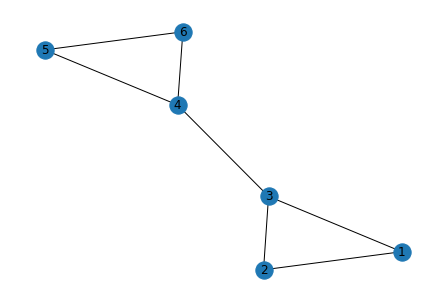

In [82]:
G_toy = nx.Graph()
G_toy.add_edges_from([(1, 2), (2, 3), (1, 3), (3, 4), (4, 5), (5, 6), (4, 6)])
nx.draw_spring(G_toy, with_labels=True)

The algorithm does not need to run if the random initialization coincides with the final results, i.e. there is no node that can be moved from A to B reducing the total number of edges between the two partitions. For example, in the toy Graph depicted above, a random initialization which is already an optimal partition is A=[1, 2, 3], B=[4, 5, 6].